# CAB420, DCNNs, Additional Example 8: 1x1 Convolutions
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will:
* Have a look at 1x1 Convolutions, and look at how they impact the size of things in the network

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras as keras
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

E0000 00:00:1738043059.409164  704677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738043059.413153  704677 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The Data

This exmaple isn't really about the data, or performance, or anything like that. Rather we're going to just play with features and embeddings. We'll use Fashion MNIST, but you could use any dataset here really.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

In [3]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = keras.ops.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

## A Model

We'll start with a simple CNN. And then we'll add some 1x1 convolutions in to see what's going on.

In [4]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

I0000 00:00:1738043062.069853  704677 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:0b.0, compute capability: 8.6


Model: "fashion_mnist_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,954 (417.79 KB)

 Trainable params: 106,954 (417.79 KB)

 Non-trainable params: 0 (0.00 B)

At this point it's worth considering what all of those numbers over in the `Param` column mean. 

Considering our first conv layer, we have:
* An input of size 28 x 28 x 1
* A 2D convolution operation, using 8 3x3 filters

Each filter is going to operate over a 3x3x1 patch of the input. So each filter has $3 \times 3 + 1$ parameters. We have 8 filters, so we have $8 \times (3 \times 3 + 1) = 80$ parameters.

If we consider the second convolution layer (after our first max-pool), it has:
* an input of size 14 x 14 x 8
* a 2D convolution operation using 16 3x3 filters

This time, each filter operates over a 3x3x8 patch of the input, so each filter has $3 \times 3 \times 8 + 1$ parameters. We have 1 bias term per channel. For our 16 filters, we then get $16 \times (3 \times 3 \times 8 + 1) = 1168$ parameters.

While it's not really relevant to our discussion in this example, we also have the dense layers, and so for the sake of completeness, considering our first dense layer:
* we have an input of size 1568
* we have an output of size 64

To go from 1568 to 64, we use a matrix product of the form $y = wx + b$. Our weight matrix, $w$, is of size $64 \times 1568$, and our bias is of size $64$, hence we have $1586 \times 64 + 64 = 100416$ parameters.

Let's train that model now and see how well it goes.

In [5]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2, verbose=False)

I0000 00:00:1738043063.329186  704712 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 - 1s - 2ms/step - accuracy: 0.9134 - loss: 0.2657
Test loss: 0.2657187283039093
Test accuracy: 0.9133999943733215
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


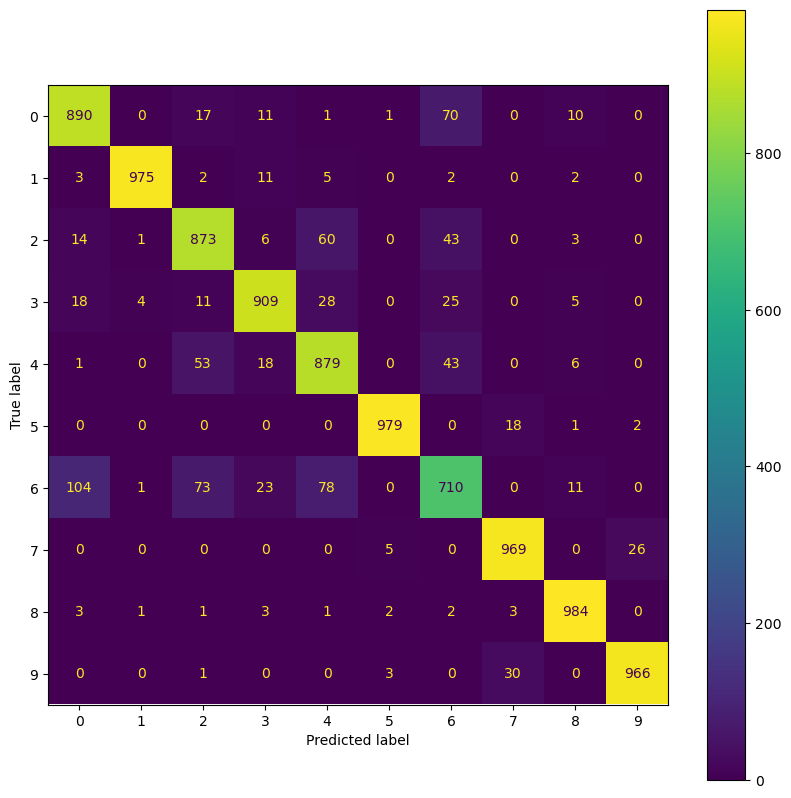

In [6]:
eval_model(model_cnn, x_test, y_test)

## 1x1 Convolutions

Let's add some 1x1 convolutions to our network. Please note, this is not really aimed at improving performance here, but rather is a way to explore what these do to the representations learned by the network.

NOTE: I'm going to name some layers in this network for visualisation later on.

In [7]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', name='before1')(x)
x = layers.Conv2D(filters=4, kernel_size=(1,1), activation='relu', padding='same', name='after1')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', name='before2')(x)
x = layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same', name='after2')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

Model: "fashion_mnist_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ before1 (Conv2D)                │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ after1 (Conv2D)                 │ (None, 14, 14, 4)      │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ before2 (Conv2D)                │ (None, 7, 7, 16)       │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ after2 (Conv2D)                 │ (None, 7, 7, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,518 (404.37 KB)

 Trainable params: 103,518 (404.37 KB)

 Non-trainable params: 0 (0.00 B)

First, let's consider what's happening either with our first 1x1 convolution. For this layer we have:
* An input of size 14x14x16
* Four 1x1 filters

Each of these filters learns a weighted sum of the $16$ input channels, hence the number of parameters is $4 \times (1 \times 1 \times 16 + 1) = 68$, i.e. the number of filters times (the filter size times the number of input channels + 1).

We see that via this layer, we go from a representation that is $14 \times 14 \times 16$ to one that is $14 \times 14 \times 4$.

Looking at our second 1x1 convolution, we have:
* An input of size 7x7x16
* 32 1x1 filters

In this case, we are using the 1x1 convolution to increase the number of channels. Our 32 1x1 filters learn 32 different weighted combinations of the input 16 channels, and thus get a higher dimensional representation in the next layer.

We most frequently see these 1x1 convolutions in situations where we're trying to either reduce features to ease computational burden (effectivley doing a channel wise pooling), or increase features so that we can perform various maths operations (like additions) with the feature maps. Whenever we need to manipulate the size something channel wise, these are an option. 

313/313 - 1s - 2ms/step - accuracy: 0.9012 - loss: 0.2864
Test loss: 0.2863958775997162
Test accuracy: 0.901199996471405
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


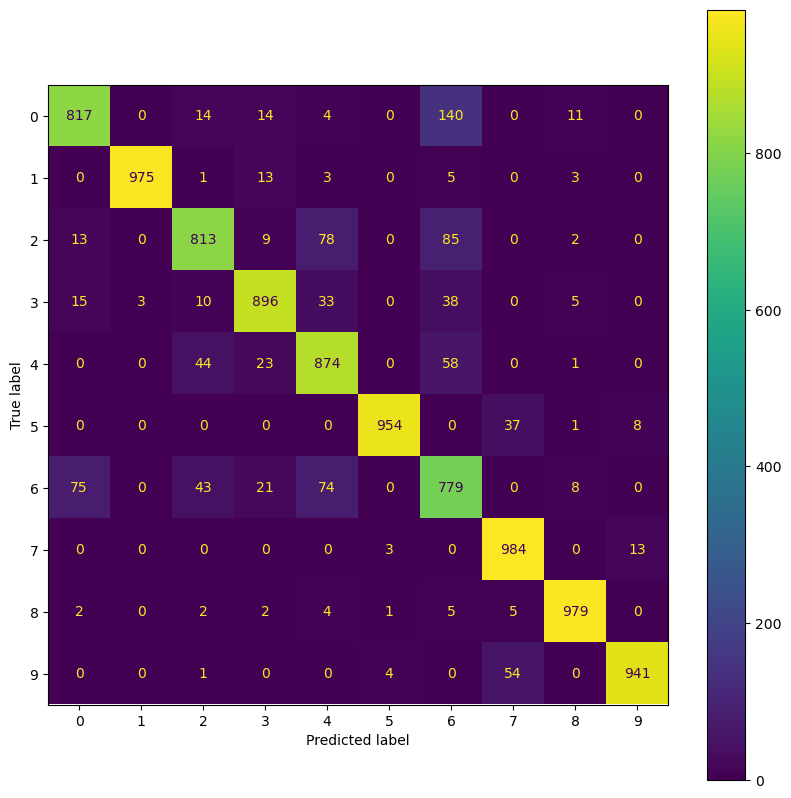

In [8]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2, verbose=False)
eval_model(model_cnn, x_test, y_test)

Our model has now been trained, but really that's not the interesting part, this next bit is when we visualise what our filters have learnt.

### Before1 Visualisation

Below we have what's coming out of 'below1', i.e. the layer before our 1x1. This is showing the activations for the first 10 images in our dataset. This is not the filter visualisations, but it does give some idea of what the network perhaps finds interesting.

I0000 00:00:1738043108.941433  704712 service.cc:148] XLA service 0x7f4f1663c330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738043108.941472  704712 service.cc:156]   StreamExecutor device (0): NVIDIA A16-4Q, Compute Capability 8.6


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


I0000 00:00:1738043109.216450  704712 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


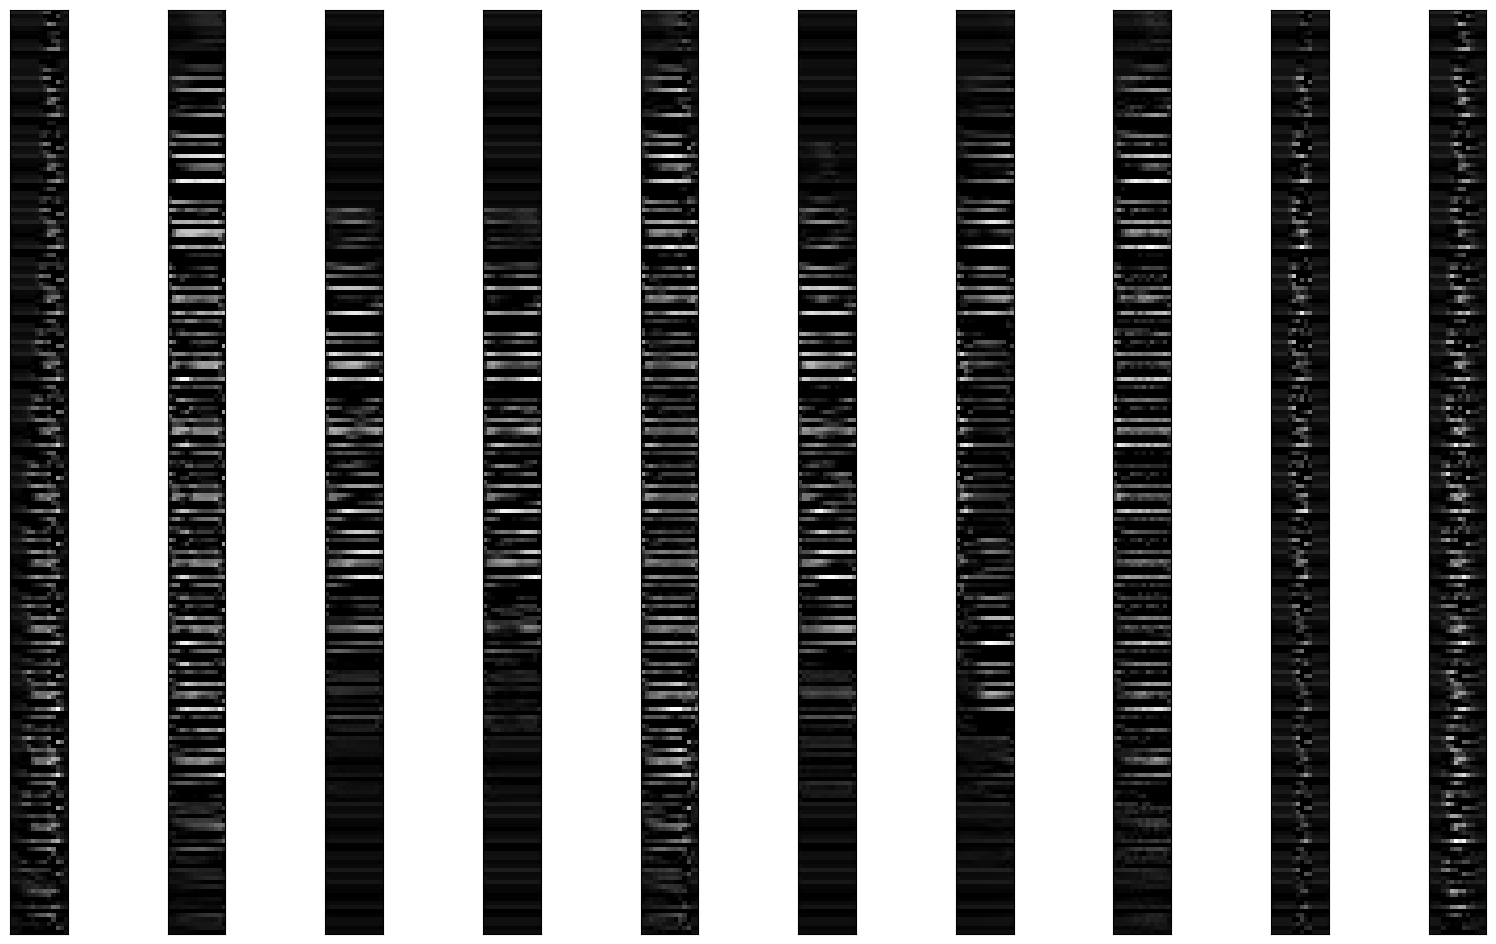

In [9]:
before1_output = model_cnn.get_layer('before1').output 
before1_model = keras.Model(inputs = model_cnn.input, outputs = before1_output)
before1_prediction = before1_model.predict(x_test[0:10,:,:,:])
    
n = 10
plt.figure(figsize=(20, 12))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(before1_prediction[i].reshape(14, 14 * 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### After1 Visualisation

This is the result of our first 1x1 convolution. This took us from 16 feature maps down to 4. Hence we can see that our activations are compressed versions of the original ones. Interestingly, the images look similar. After1 is like a compressed (or squished) version of what we had in before1. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


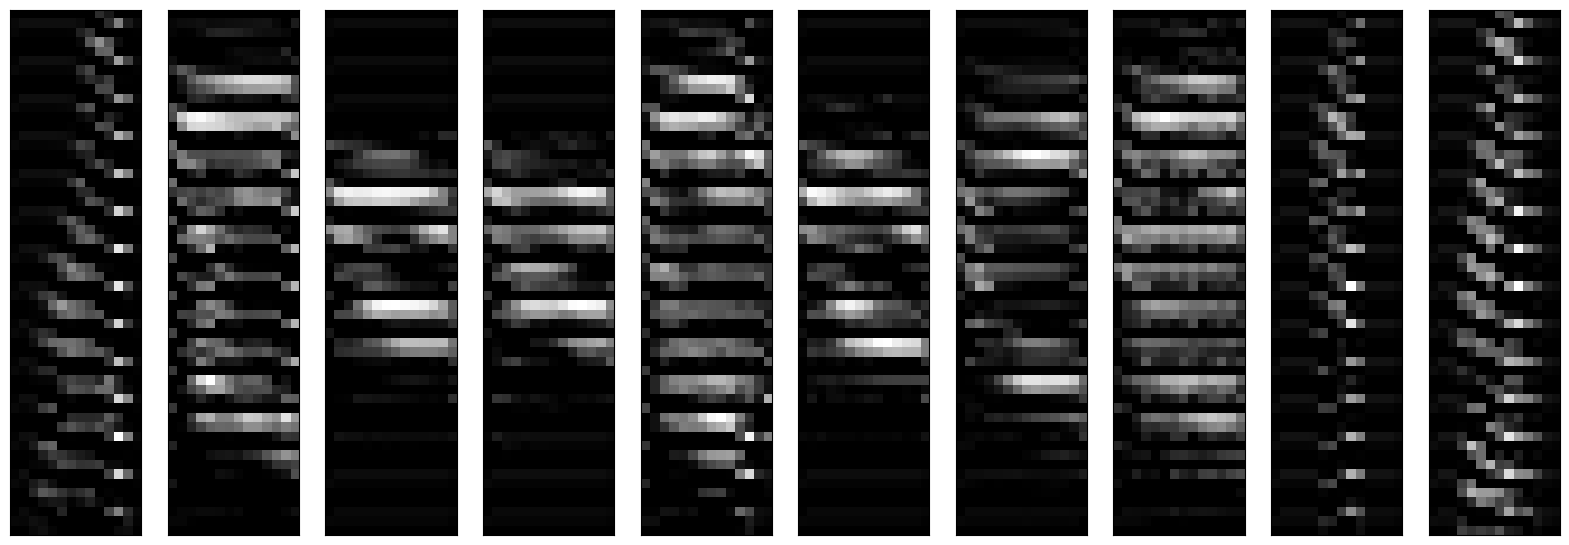

In [10]:
after1_output = model_cnn.get_layer('after1').output 
after1_model = keras.Model(inputs = model_cnn.input, outputs = after1_output)
after1_prediction = after1_model.predict(x_test[0:10,:,:,:])
    
n = 10
plt.figure(figsize=(20, 12))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(after1_prediction[i].reshape(14, 14 * 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


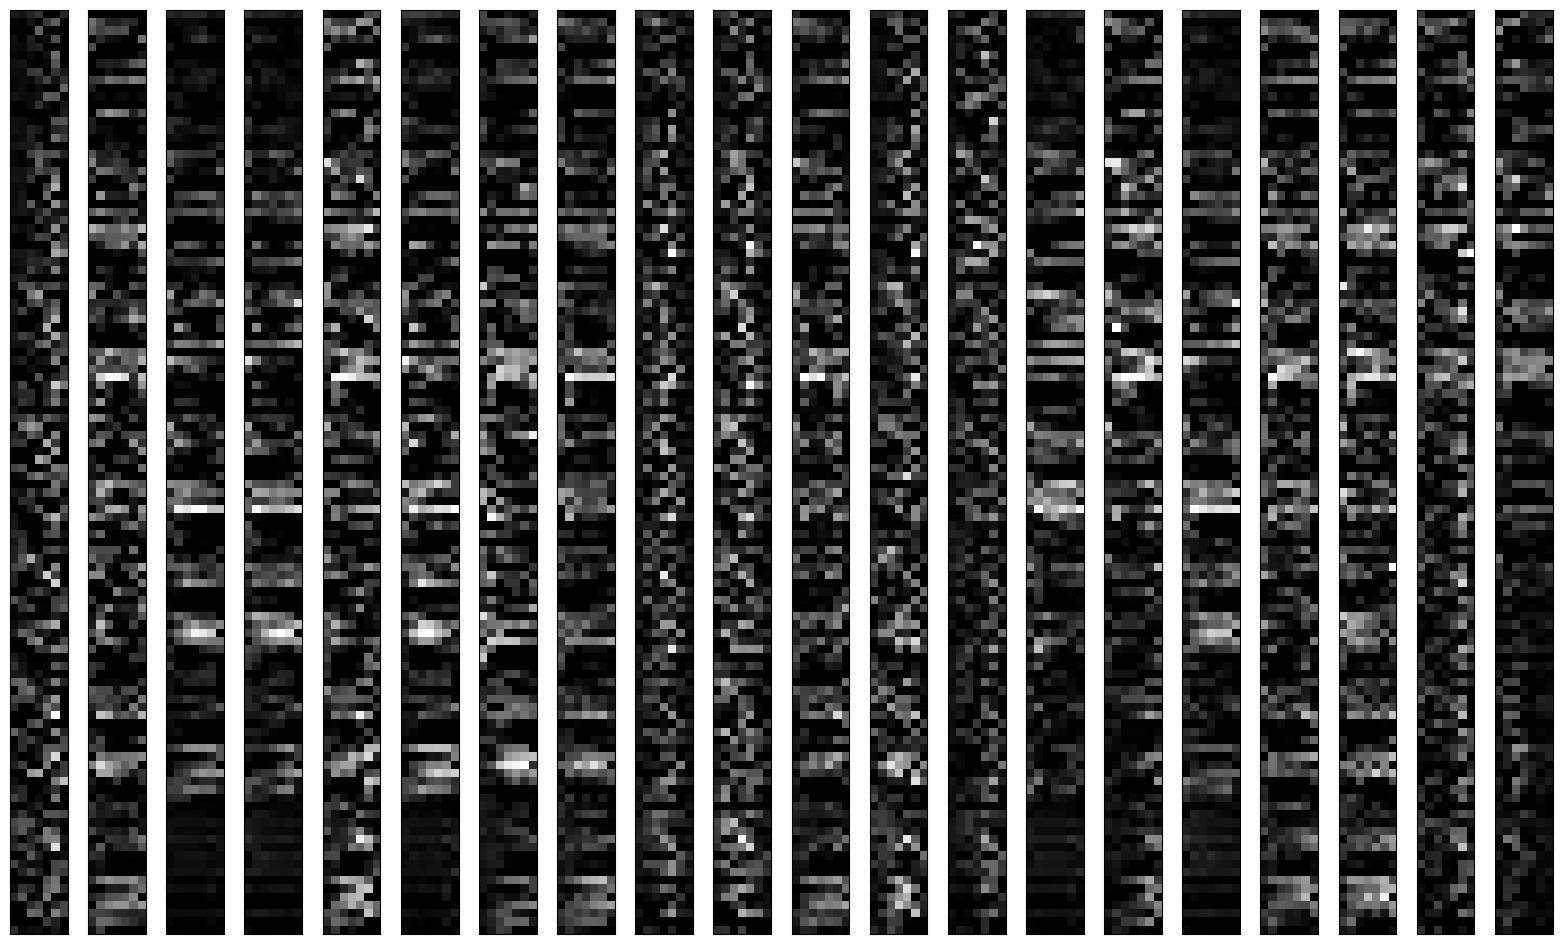

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


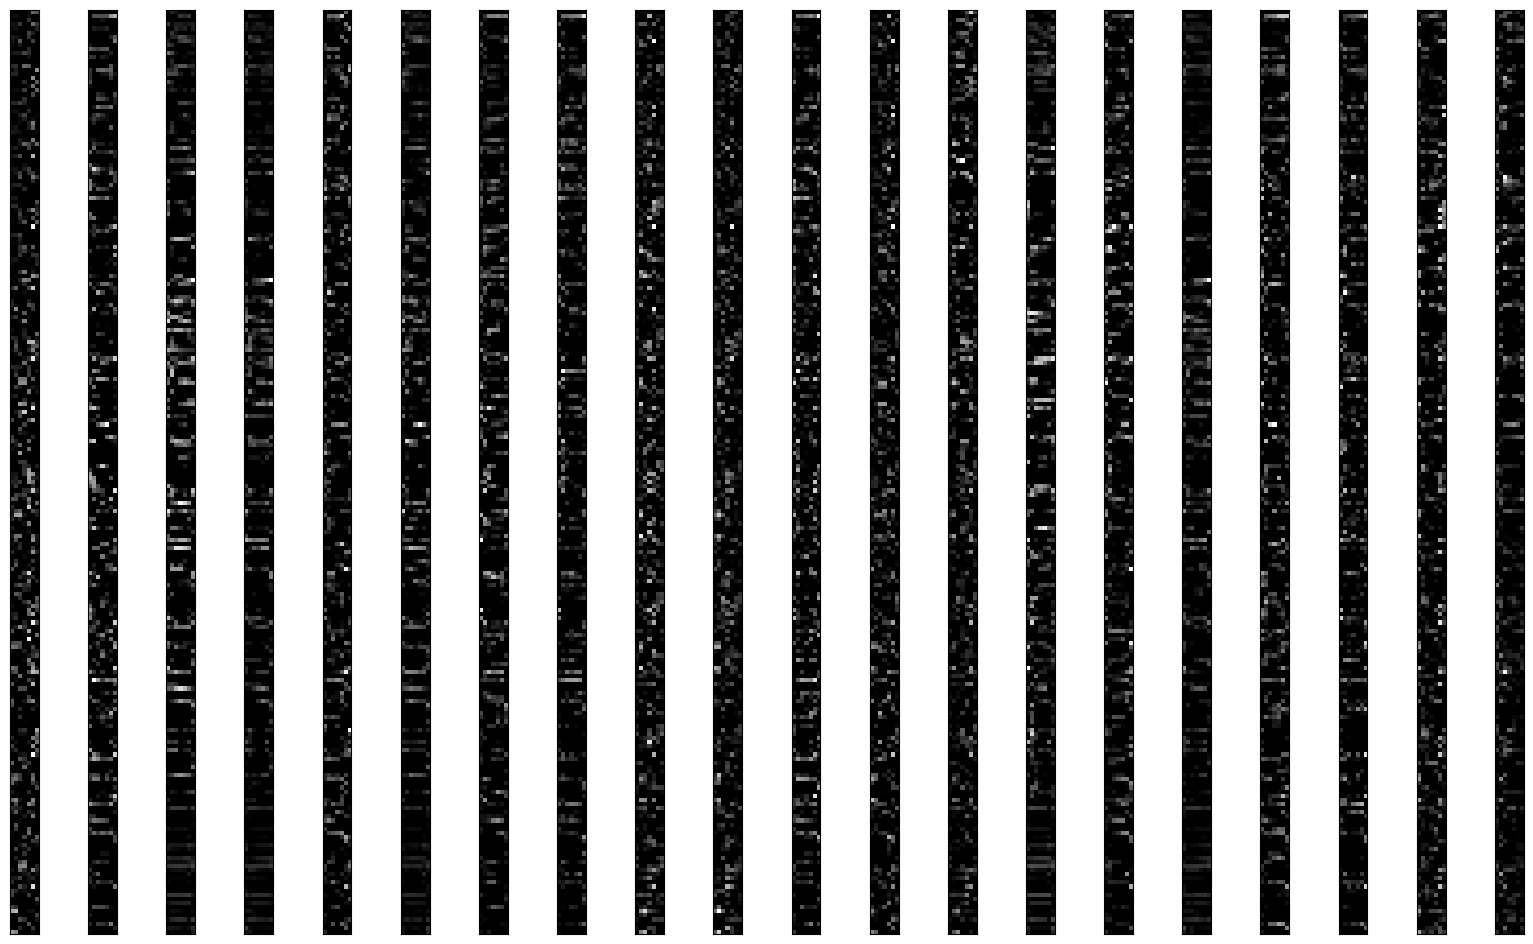

In [11]:
n = 20
before2_output = model_cnn.get_layer('before2').output 
before2_model = keras.Model(inputs = model_cnn.input, outputs = before2_output)
before2_prediction = before2_model.predict(x_test[0:n,:,:,:])
    
plt.figure(figsize=(20, 12))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(before2_prediction[i].reshape(7, 7 * 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

after2_output = model_cnn.get_layer('after2').output 
after2_model = keras.Model(inputs = model_cnn.input, outputs = after2_output)
after2_prediction = after2_model.predict(x_test[0:n,:,:,:])
    
plt.figure(figsize=(20, 12))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(after2_prediction[i].reshape(7, 7 * 32).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Looking at the results for before2 and after2, the smaller size makes them a bit harder to interpret, but we can see that the patterns have (roughly) been spread out or stretched, effectively the inverse of what we saw before.

## Final Thoughts

So what exactly is the point of 1x1 convolution layers?

They are a bit of an odd one, but we can think of these as learning patterns across channels. They can allow us to compress some internal representation by reducing the number of channels. This can be used to help remove redundant or unhelpful information, and by reducing the size of a representation we can have later layers with fewer parameters; good for both efficiency and avoiding overfitting.

Their other use is in expanding the number of channels. This is usually used when we want to combine two represenations in some way. For example we may wish to add two stacks of filter results, but unless we have the same number of channels in each, we can't do such an operation. A 1x1 convolution gives us an option to make this happen.